In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

# Data Understanding
There is 284807 observation of 31 variable. Class is target variable where as others are predictor variable. Information given in data is sesitive so i think data has been preprocessed with technique such as PCA or Factor Analysis, So we need not to put extra effort on Data Cleaning and Wrangling. Out of 284807 only 492 observations are detected Fraud so this data is highly imbalanced we will use different sampling technique to increase accuracy.

In [2]:
df=pd.read_csv('../input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

In [4]:
all(df.isnull().any())

False

**There is no missing value**

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
print((492/(284807+492))*100)

0.1724506570299931


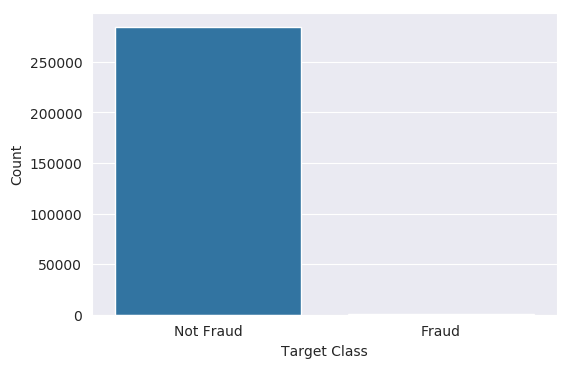

In [7]:
plt.figure(dpi=100)
sns.set_style('darkgrid')
sns.countplot('Class',data=df)
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks([0,1],['Not Fraud','Fraud'])
plt.show()

**Dataset is highly imbalanced, only 0.17 % obseravations are detected as Fraud**

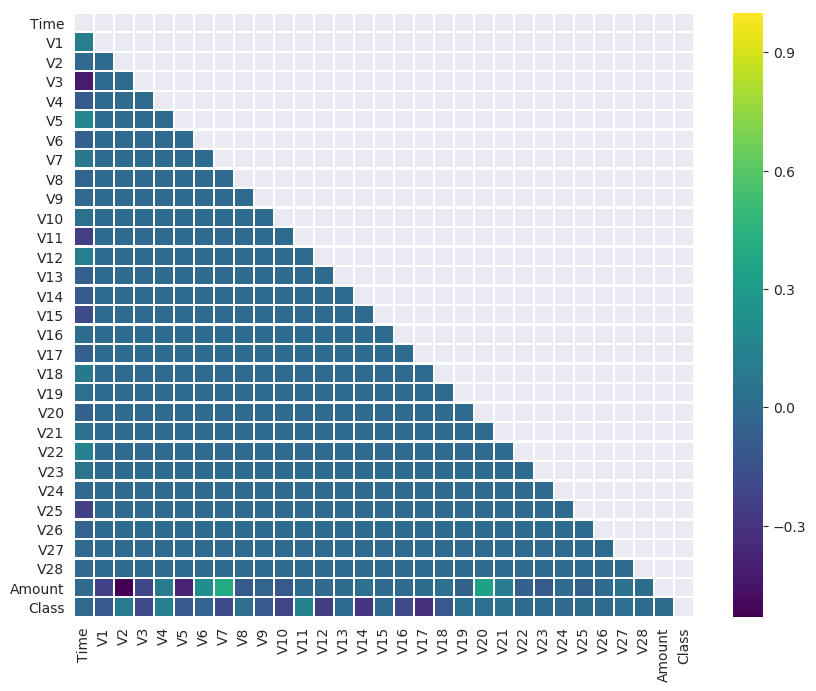

In [8]:
mask = np.triu(np.ones_like(df.corr(),dtype=bool))
plt.figure(dpi=100,figsize=(10,8))
sns.heatmap(df.corr(),yticklabels=True,mask=mask,cmap='viridis',annot=False, lw=1)
plt.show()

**We can see there are only less variable which are weakly correalted with class, May be this is because data is already reduced to lower domension using PCA and other Feature engineering method and these varables are explaining significant variance in data**

# Data Reshampling
Here i am reshampling data using **SMOTE** method because dataset is imbalaned.

In [9]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [10]:
print((x.shape,y.shape))

((284807, 30), (284807,))


In [11]:
from imblearn.combine import SMOTETomek
smk=SMOTETomek(ratio=1,random_state=0)
x_new,y_new=smk.fit_sample(x,y)


Using TensorFlow backend.


In [12]:
print(x_new.shape,y_new.shape)

(567528, 30) (567528,)


In [13]:

from sklearn.model_selection import train_test_split as tts
x_train,x_test,y_train,y_test=tts(x_new,y_new,test_size=0.80,random_state=0,stratify=y_new)

In [14]:

print(x_train.shape,x_test.shape)

(113505, 30) (454023, 30)


# Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegression
lrm=LogisticRegression(C=0.1,penalty='l1',n_jobs=-1)
lrm.fit(x_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
y_pred=lrm.predict(x_test)

# Model Evaluation

In [17]:
print("Train Set Accuracy is ==> ",metrics.accuracy_score(y_train,lrm.predict(x_train)))
print("Test Set Accuracy is ==> ",metrics.accuracy_score(y_test,y_pred))

Train Set Accuracy is ==>  0.9797718162195498
Test Set Accuracy is ==>  0.980304962523925


In [18]:
print("Classification Report on Hold Out Dataset==>\n\n",metrics.classification_report(y_test,y_pred))

Classification Report on Hold Out Dataset==>

               precision    recall  f1-score   support

           0       0.97      0.99      0.98    227012
           1       0.99      0.97      0.98    227011

    accuracy                           0.98    454023
   macro avg       0.98      0.98      0.98    454023
weighted avg       0.98      0.98      0.98    454023



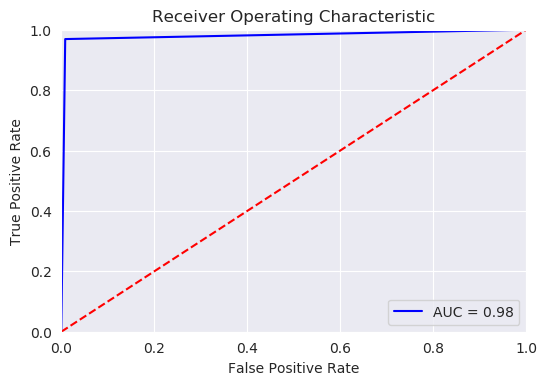

In [19]:
probs = lrm.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(dpi=100)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Model is validated , we can see accuracy at both train and test set is almost sam which means model is not overfitting, ROC-AUC score is also enough good 0.98.**

### Please Upvote this kernel, if it is useful for you :)